# IT3212 - Assignment 2

## Setup

### Importing libraries

In [289]:
# Standard libraries
import numpy as np  
import pandas as pd
import re
import string

# NLTK tools and datasets
import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Uncomment if you need to download NLTK data packages
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('vader_lexicon')

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Miscellaneous
from collections import Counter
from urllib.parse import unquote
from textblob import TextBlob
import contractions
from scipy import stats
import chardet

### Fix dataset encoding issues

In [290]:
# Some rows in the raw data include non UTF-8 characters. 

# Example of text with non UTF-8 characters:
# 778245336,FALSE,finalized,5,8/30/15 13:27,Not Relevant,0.7952,,army,
# text column: Pakistan,".: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: RT DrAyesha4: #IndiaKoMunTorJawabDo Indian Army ki��_ http://t.co/WJLJq3yA4g"
# ,6.29079E+17,195397186

# Chardet identifies the encoding of the raw data as 'MacRoman'.
# For now, we will remove all non UTF-8 characters from the raw data
# We handle this by removing all � characters from the raw data and writing the modified content back to the file.

def fix_non_utf8_encoding(filepath, destination_filepath):
    with open(filepath, 'rb') as file:
        rawdata = file.read()
        result = chardet.detect(rawdata)
        print(result['encoding'])


    # Open the file in read mode, read its contents, then close it
    with open('data/disaster-tweets.csv', 'r', encoding='utf-8', errors='ignore') as file:
        content = file.read()

    # Remove all � characters
    content = content.replace('�', '')

    # Open the file in write mode and write the modified content back to it
    with open(destination_filepath, 'w', encoding='utf-8') as file:
        file.write(content)

filepath = 'data/disaster-tweets.csv'
dest = 'data/disaster-tweets-utf8.csv'

# fix_non_utf8_encoding(filepath, dest)

In [291]:
def split_train_test(filepath, destination_filepath_train, destination_filepath_test):
    df = pd.read_csv(filepath, encoding='utf-8')
    train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
    train_data = train_data.reset_index(drop=True)
    test_data = test_data.reset_index(drop=True)
    train_data.to_csv(destination_filepath_train, index=False)
    test_data.to_csv(destination_filepath_test, index=False)

filepath = 'data/disaster-tweets-utf8.csv'
dest_train = 'data/train.csv'
dest_test = 'data/test.csv'

# split_train_test(filepath, dest_train, dest_test)

In [292]:
# Dataframe with data to be used in training
df = pd.read_csv('./data/train.csv', encoding='utf-8')
df_test = pd.read_csv('./data/test.csv', encoding='utf-8')
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid
0,778253309,False,finalized,5,8/27/15 16:07,Not Relevant,1.0000,NaN,screamed,NaN,i dont even remember slsp happening i just remember being like wtf and then the lights turned off and everyone screamed for the encore,6.291070e+17,2.327739e+08
1,778251995,False,finalized,5,8/27/15 20:16,Not Relevant,1.0000,NaN,mudslide,Edinburgh,@hazelannmac ooh now I feel guilty about wishing hatman out. I bet the mudslide was delicious!,6.290180e+17,2.750220e+07
2,778247239,False,finalized,5,8/30/15 0:15,Not Relevant,1.0000,NaN,collide,planeta H2o,Soultech - Collide (Club Mix) http://t.co/8xIxBsPOT8,6.290920e+17,6.052387e+08
3,778255430,False,finalized,5,8/27/15 17:03,Relevant,0.7978,NaN,wounded,NaN,Police Officer Wounded Suspect Dead After Exchanging Shots - http://t.co/iPHaZV47g7,6.291190e+17,2.305930e+09
4,778255609,False,finalized,5,8/27/15 22:11,Not Relevant,1.0000,NaN,wrecked,Sunny Southern California,Cramer: Iger's 3 words that wrecked Disney's stock http://t.co/4dGpBAiVL7,6.290800e+17,2.464266e+07


## Feature extraction before preprocessing

Some extracted features of interest must be done before preprocessing any data. These features are:

- `hashtag_count`: number of hashtags in the tweet
- `mention_count`: number of mentions in the tweet
- `has_url`: whether the tweet contains a URL

In [293]:

def extract_features(df): 
    # Extract the number of hashtags
    df["hashtag_count"] = df["text"].apply(lambda x: len([c for c in str(x) if c == "#"]))

    # Extract the number of mentions
    df["mention_count"] = df["text"].apply(lambda x: len([c for c in str(x) if c == "@"]))

    # Extract the `has_url` feature
    df["has_url"] = df["text"].apply(lambda x: 1 if "http" in str(x) else 0)

    return df

# Write the updated dataframe to a CSV file
df = extract_features(df)
df_test = extract_features(df_test)
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid,hashtag_count,mention_count,has_url
0,778253309,False,finalized,5,8/27/15 16:07,Not Relevant,1.0000,NaN,screamed,NaN,i dont even remember slsp happening i just remember being like wtf and then the lights turned off and everyone screamed for the encore,6.291070e+17,2.327739e+08,0,0,0
1,778251995,False,finalized,5,8/27/15 20:16,Not Relevant,1.0000,NaN,mudslide,Edinburgh,@hazelannmac ooh now I feel guilty about wishing hatman out. I bet the mudslide was delicious!,6.290180e+17,2.750220e+07,0,1,0
2,778247239,False,finalized,5,8/30/15 0:15,Not Relevant,1.0000,NaN,collide,planeta H2o,Soultech - Collide (Club Mix) http://t.co/8xIxBsPOT8,6.290920e+17,6.052387e+08,0,0,1
3,778255430,False,finalized,5,8/27/15 17:03,Relevant,0.7978,NaN,wounded,NaN,Police Officer Wounded Suspect Dead After Exchanging Shots - http://t.co/iPHaZV47g7,6.291190e+17,2.305930e+09,0,0,1
4,778255609,False,finalized,5,8/27/15 22:11,Not Relevant,1.0000,NaN,wrecked,Sunny Southern California,Cramer: Iger's 3 words that wrecked Disney's stock http://t.co/4dGpBAiVL7,6.290800e+17,2.464266e+07,0,0,1


##  Exploratory data analysis (EDA)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid,hashtag_count,mention_count,has_url
0,778253309,False,finalized,5,8/27/15 16:07,Not Relevant,1.0000,NaN,screamed,NaN,i dont even remember slsp happening i just remember being like wtf and then the lights turned off and everyone screamed for the encore,6.291070e+17,2.327739e+08,0,0,0
1,778251995,False,finalized,5,8/27/15 20:16,Not Relevant,1.0000,NaN,mudslide,Edinburgh,@hazelannmac ooh now I feel guilty about wishing hatman out. I bet the mudslide was delicious!,6.290180e+17,2.750220e+07,0,1,0
2,778247239,False,finalized,5,8/30/15 0:15,Not Relevant,1.0000,NaN,collide,planeta H2o,Soultech - Collide (Club Mix) http://t.co/8xIxBsPOT8,6.290920e+17,6.052387e+08,0,0,1
3,778255430,False,finalized,5,8/27/15 17:03,Relevant,0.7978,NaN,wounded,NaN,Police Officer Wounded Suspect Dead After Exchanging Shots - http://t.co/iPHaZV47g7,6.291190e+17,2.305930e+09,0,0,1
4,778255609,False,finalized,5,8/27/15 22:11,Not Relevant,1.0000,NaN,wrecked,Sunny Southern California,Cramer: Iger's 3 words that wrecked Disney's stock http://t.co/4dGpBAiVL7,6.290800e+17,2.464266e+07,0,0,1


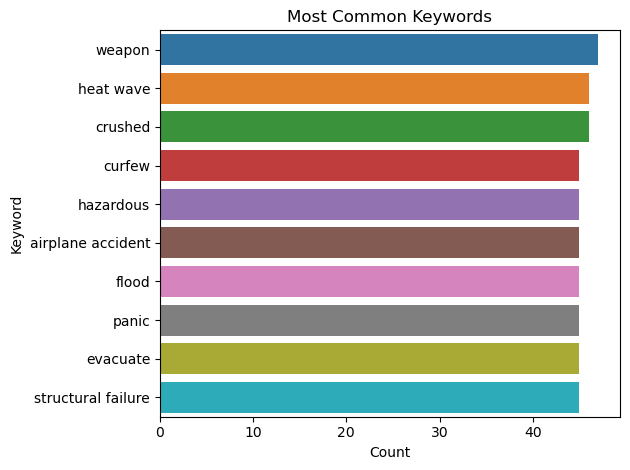

<bound method IndexOpsMixin.value_counts of 0               screamed
1               mudslide
2                collide
3                wounded
4                wrecked
              ...       
8695         forest fire
8696          fatalities
8697          fire truck
8698           bioterror
8699    nuclear disaster
Name: keyword, Length: 8700, dtype: object>


In [295]:
# Clean `keyword` column.
def clean_keyword(keyword: str):
    return unquote(keyword) if pd.notnull(keyword) else ''

df['keyword'] = df['keyword'].apply(clean_keyword).apply(str.lower)

# Write the updated dataframe to a new CSV file
df.to_csv('./results/02-clean-keywords.csv', index=False)
display(df.head())

# Plot the most common keywords

defined_keywords = df[df['keyword'] != '']['keyword']

plt.figure()
sns.countplot(y=defined_keywords, order=defined_keywords.value_counts().iloc[:10].index)
plt.title('Most Common Keywords')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.tight_layout()
plt.savefig('./results/03-keywords.png')
plt.show()





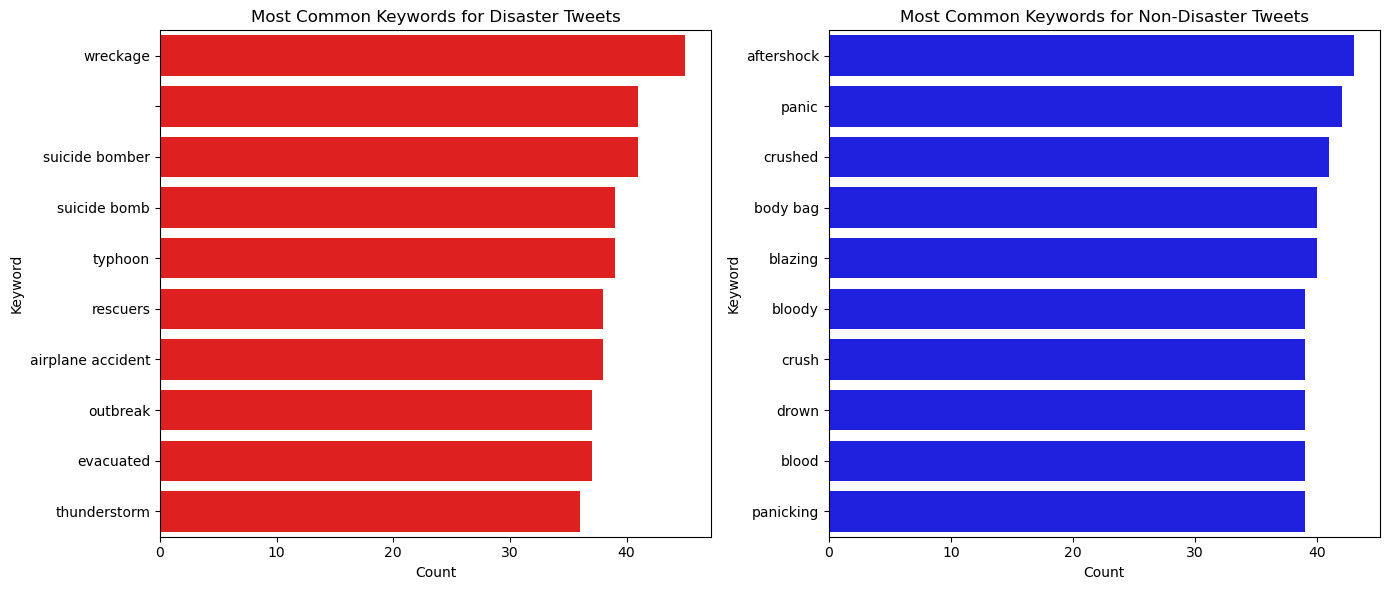

In [256]:
# Compare keywords for disaster tweets and non-disaster tweets
disaster_keywords = df[df['choose_one'] == 'Relevant']['keyword']
non_disaster_keywords = df[df['choose_one'] == 'Not Relevant']['keyword']

# Create a figure object and define the grid
fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Plotting
sns.countplot(y=disaster_keywords, ax=ax[0], order=disaster_keywords.value_counts().iloc[:10].index, color='red')
sns.countplot(y=non_disaster_keywords, ax=ax[1], order=non_disaster_keywords.value_counts().iloc[:10].index, color='blue')

# Titles and labels
ax[0].set_title('Most Common Keywords for Disaster Tweets')
ax[0].set_xlabel('Count')
ax[0].set_ylabel('Keyword')

ax[1].set_title('Most Common Keywords for Non-Disaster Tweets')
ax[1].set_xlabel('Count')
ax[1].set_ylabel('Keyword')

# Adjust layout
plt.tight_layout()
plt.savefig('./results/keywords_comparison.png')
plt.show()



In the plot above, we can see that the top 10 shared keywords of disaster-related tweets and non-disaster-related tweets do not share any common keywords.

In [297]:

# sns.countplot(x='choose_one', data=df)
# plt.title('Number of Tweets with Target Value of 1 and 0') 


keyword
                       62
weapon                 47
heat wave              46
crushed                46
evacuate               45
                       ..
forest fire            17
inundation             12
epicentre              12
radiation emergency    11
threat                 11
Name: count, Length: 222, dtype: int64


## 1. Preprocessing

### Remove entries with low confidence in labling

In [258]:
initial_count = df.shape[0]
# Remove rows with a confidence score less than 1.0
confidence_threshold = 0.7
df = df[df['choose_one:confidence'] >= confidence_threshold]
df = df[df['choose_one'] != "Can't Decide"]

print("Number of rows removed: {}".format(initial_count - df.shape[0]))

Number of rows removed: 2167


All entries with can't decide belonged in the set with confidence under treshold 

In [259]:
df.columns

Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'choose_one', 'choose_one:confidence',
       'choose_one_gold', 'keyword', 'location', 'text', 'tweetid', 'userid',
       'hashtag_count', 'mention_count', 'has_url'],
      dtype='object')

### 1.1 Delete features that are not useful

In [309]:
# original_features: _unit_id, _golden, _unit_state, _trusted_judgments, _last_judgment_at, choose_one, choose_one:confidence, choose_one_gold, keyword, location, text, tweetid, userid
features_to_keep = ['y', 'text', 'keyword', 'hashtag_count', 'mention_count', 'has_url']

# map choose one to 1 or 0, call it y to be consistent with ml conventions
df['y'] = df['choose_one'].apply(lambda x: 1 if x == 'Relevant' else 0)
df = df[features_to_keep]

df_test['y'] = df_test['choose_one'].apply(lambda x: 1 if x == 'Relevant' else 0)
df_test = df_test[features_to_keep]

display(df_test.head())

,y,text,keyword,hashtag_count,mention_count,has_url
0,1,The sunset looked like an erupting volcano .... My initial thought was the Pixar short Lava http://t.co/g4sChqFEsT,volcano,0,0,1
1,1,#7294 Nikon D50 6.1 MP Digital SLR Camera Body 2 batteries carry bag and charger http://t.co/SL7PHqSGKV\n\n$200.00\n_ http://t.co/T4Qh2OM8Op,body%20bag,1,0,1
2,0,Mental/Twitter Note: Make sure my smoke alarm battery is up to snuff at all times or face many twitter reminders of changing my battery.,smoke,0,0,0
3,0,?????? EMERGENCY ?????? NEED PART 2 and 3!!! #NashNewVideo http://t.co/TwdnNaIOns @Nashgrier 103,emergency,1,1,1
4,0,WHELEN MODEL 295SS-100 SIREN AMPLIFIER POLICE EMERGENCY VEHICLE - Full read by eBay http://t.co/Q3yYQi4A27 http://t.co/whEreofYAx,siren,0,0,1


### 1.2 Text processing

In [261]:
lemmatizer = WordNetLemmatizer()
tokenizer = TweetTokenizer()

def clean_text(text: str):
  text = re.sub(r'https?://\S+', '', text)  # Remove links
  text = re.sub(r'\n', ' ', text)  # Remove line breaks
  text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
  text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
  text = text.lower()
  text = ' '.join([word for word in text.split() if word not in stopwords.words("english")])
  text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
  text = contractions.fix(text)
  text = tokenizer.tokenize(text)
  text = ' '.join(text)

  return text

# show head of text column
display(df['text'])

df['text'] = df['text'].apply(lambda x: clean_text(x))
df_test['text'] = df_test['text'].apply(lambda x: clean_text(x))
df.head()

0       i dont even remember slsp happening i just remember being like wtf and then the lights turned off and everyone screamed for the encore
1                                               @hazelannmac ooh now I feel guilty about wishing hatman out. I bet the mudslide was delicious!
2                                                                                         Soultech - Collide (Club Mix) http://t.co/8xIxBsPOT8
3                                                          Police Officer Wounded Suspect Dead After Exchanging Shots - http://t.co/iPHaZV47g7
4                                                                    Cramer: Iger's 3 words that wrecked Disney's stock http://t.co/4dGpBAiVL7
                                                                         ...                                                                  
8695                                         How is it one careless match can start a forest fire but it takes a whole box to start a campfire

,y,text,keyword,hashtag_count,mention_count,has_url
0,0,do not even remember slsp happening remember like wtf light turned everyone screamed encore,screamed,0,0,0
1,0,hazelannmac ooh feel guilty wishing hatman bet mudslide delicious,mudslide,0,1,0
2,0,soultech collide club mix,collide,0,0,1
3,1,police officer wounded suspect dead exchanging shot,wounded,0,0,1
4,0,cramer igers 3 word wrecked disney stock,wrecked,0,0,1


### 1.4 Duplicated data

In [262]:
count_initial = df.shape[0]

# Remove duplicated rows with respect to the `text` column
df = df.drop_duplicates(subset=['text'])

print("Removed {} duplicated rows.".format(count_initial - df.shape[0]))

Removed 638 duplicated rows.


## 2. Extracting features

In [263]:
# Create new column for text length
df['text_length'] = df['text'].apply(len)
df_test['text_length'] = df_test['text'].apply(len)

## Sentiment analysis


In [275]:

from nltk.sentiment.vader import SentimentIntensityAnalyzer

def analyze_sentiment_vader(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = analyzer.polarity_scores(text)
    return sentiment_scores['compound']

df['sentiment'] = df['text'].apply(analyze_sentiment_vader)
df_test['sentiment'] = df_test['text'].apply(analyze_sentiment_vader)

df.sentiment.head()

0   -0.5574
1    0.4215
2   -0.0772
3   -0.7579
4    0.0000
Name: sentiment, dtype: float64

## Checking if sentiment and target is correlated


In [276]:
from scipy import stats

disaster_group = df[df['y'] == 1]['sentiment']
not_disaster_group = df[df['y'] == 0]['sentiment']

t_statistic, p_value = stats.ttest_ind(disaster_group, not_disaster_group, equal_var=False)

print(p_value)
if p_value < 0.05:
    print("There is a significant difference in sentiment between disaster and not disaster tweets.")
else:
    print("There is no significant difference in sentiment between disaster and not disaster tweets.")

3.520081770393815e-102
There is a significant difference in sentiment between disaster and not disaster tweets.


## Create ngrams

In [277]:
def create_ngrams(text, n):
    tokens = word_tokenize(text)
    n_grams = list(ngrams(tokens, n))
    return n_grams


df['bigrams'] = df['text'].apply(lambda x: create_ngrams(x, 2))
df['trigrams'] = df['text'].apply(lambda x: create_ngrams(x, 3))

df_test['bigrams'] = df_test['text'].apply(lambda x: create_ngrams(x, 2))
df_test['trigrams'] = df_test['text'].apply(lambda x: create_ngrams(x, 3))

## Count number of occurences of ngrams in each category


### Bigrams

In [278]:

disaster_bigrams = df[df['y'] == 1]['bigrams']
non_disaster_bigrams = df[df['y'] == 0]['bigrams']

disaster_bigram_counts = Counter([gram for ngram_list in disaster_bigrams for gram in ngram_list])
non_disaster_bigram_counts = Counter([gram for ngram_list in non_disaster_bigrams for gram in ngram_list])

print("Most common n-grams in disaster-related tweets:")
print(disaster_bigram_counts.most_common(10))


print("\nMost common n-grams in non-disaster tweets:")
print(non_disaster_bigram_counts.most_common(10))

Most common n-grams in disaster-related tweets:
[(('suicide', 'bomber'), 47), (('do', 'not'), 34), (('i', 'am'), 33), (('severe', 'thunderstorm'), 32), (('suicide', 'bombing'), 28), (('wild', 'fire'), 28), (('thunderstorm', 'warning'), 26), (('severe_thunderstorm', 'thunderstorm_warning'), 26), (('heat', 'wave'), 25), (('northern', 'california'), 24)]

Most common n-grams in non-disaster tweets:
[(('i', 'am'), 230), (('do', 'not'), 126), (('can', 'not'), 77), (('you', 'are'), 74), (('going', 'to'), 41), (('youtube', 'video'), 30), (('i', 'have'), 30), (('that', 'is'), 30), (('liked', 'youtube'), 29), (('liked_youtube', 'youtube_video'), 29)]


### Trigrams

In [279]:
disaster_trigrams = df[df['y'] == 1]['trigrams']
non_disaster_trigrams = df[df['y'] == 0]['trigrams']

disaster_trigram_counts = Counter([gram for ngram_list in disaster_trigrams for gram in ngram_list])
non_disaster_trigram_counts = Counter([gram for ngram_list in non_disaster_trigrams for gram in ngram_list])

print("Most common trigrams in disaster-related tweets:")
print(disaster_trigram_counts.most_common(10))


print("\nMost common trigrams in non-disaster tweets:")
print(non_disaster_trigram_counts.most_common(10))

Most common trigrams in disaster-related tweets:
[(('severe', 'thunderstorm', 'warning'), 26), (('suicide', 'bomber', 'kill'), 17), (('suicide', 'bomber', 'detonated'), 17), (('pkk', 'suicide', 'bomber'), 15), (('bomber', 'detonated', 'bomb'), 15), (('pkk_suicide', 'suicide_bomber', 'bomber_detonated'), 15), (('suicide_bomber', 'bomber_detonated', 'detonated_bomb'), 15), (('pkk_suicide_bomber', 'suicide_bomber_detonated', 'bomber_detonated_bomb'), 15), (('northern', 'california', 'wildfire'), 15), (('officer', 'wounded', 'suspect'), 14)]

Most common trigrams in non-disaster tweets:
[(('liked', 'youtube', 'video'), 29), (('i', 'am', 'going'), 20), (('pick', 'fan', 'army'), 16), (('likely', 'rise', 'top'), 14), (('rise', 'top', 'pay'), 14), (('top', 'pay', 'pile'), 14), (('pay', 'pile', 'business_deluged'), 13), (('do', 'not', 'know'), 13), (('ignition', 'knock', 'detonation'), 12), (('likely_rise', 'rise_top', 'top_pay'), 12)]


In [280]:
def create_ngrams_string(ngram_list):
    ngram_words = ['_'.join(ngram) for ngram in ngram_list]
    ngram_string = ' '.join(ngram_words)
    return ngram_string
# Sample trigrams and bigrams data

df['bigrams'] = df['bigrams'].apply(lambda x: create_ngrams_string(x))
df['trigrams'] = df['trigrams'].apply(lambda x: create_ngrams_string(x))

df['text'] = df['text'] + ' ' +  df['bigrams'] + ' ' + df['trigrams'] 



In [308]:
df_test.describe()

,_unit_id,_trusted_judgments,choose_one:confidence,tweetid,userid,hashtag_count,mention_count,has_url
count,2.176000e+03,2176.000000,2176.000000,2.176000e+03,2.151000e+03,2176.000000,2176.000000,2176.000000
mean,7.782503e+08,6.400276,0.843340,6.218138e+17,1.183071e+09,0.431985,0.383272,0.538603
std,3.240839e+03,12.433517,0.167148,6.705325e+16,1.154429e+09,1.059589,0.759416,0.498622
min,7.782438e+08,5.000000,0.399400,1.000000e+00,6.601030e+05,0.000000,0.000000,0.000000
25%,7.782476e+08,5.000000,0.795200,6.290590e+17,1.633472e+08,0.000000,0.000000,0.000000
50%,7.782503e+08,5.000000,0.804750,6.290920e+17,6.158590e+08,0.000000,0.000000,1.000000
75%,7.782530e+08,5.000000,1.000000,6.292535e+17,2.358885e+09,0.000000,1.000000,1.000000
max,7.782611e+08,156.000000,1.000000,6.293650e+17,3.403263e+09,13.000000,10.000000,1.000000


In [322]:
defined_keywords = df_test['keyword'].unique()
defined_keywords = defined_keywords[~pd.isnull(defined_keywords)]
defined_keywords
# len(df_test)

# # save to csv
# df_test[df_test['keyword'] != '""']['keyword'].to_csv('test.csv', index=False)

# plt.figure()
# sns.countplot(y=defined_keywords, order=defined_keywords.value_counts().iloc[:10].index)
# plt.title('Most Common Keywords')
# plt.xlabel('Count')
# plt.ylabel('Keyword')
# plt.tight_layout()
# plt.show()

array(['volcano', 'body%20bag', 'smoke', 'emergency', 'siren', 'trauma',
       'ruin', 'collided', 'army', 'stretcher', 'electrocute',
       'buildings%20burning', 'violent%20storm', 'meltdown', 'evacuate',
       'trapped', 'drought', 'outbreak', 'deaths', 'annihilated',
       'electrocuted', 'inundation', 'mass%20murder', 'explode', 'threat',
       'survivors', 'danger', 'thunderstorm', 'blight', 'apocalypse',
       'bleeding', 'radiation%20emergency', 'survived', 'twister',
       'blaze', 'traumatised', 'snowstorm', 'sunk', 'injury',
       'forest%20fires', 'arson', 'loud%20bang', 'riot', 'engulfed',
       'screaming', 'casualties', 'thunder', 'screamed',
       'burning%20buildings', 'whirlwind', 'screams', 'terrorism',
       'chemical%20emergency', 'police', 'floods', 'dead', 'hailstorm',
       'crashed', 'war%20zone', 'bioterror', 'derailment', 'eyewitness',
       'crush', 'ambulance', 'wounds', 'collapse', 'rescued', 'weapon',
       'emergency%20services', 'storm', '

### Extracting features from keyword

In [323]:
# Using TF-IDF Vectorizer 

# Initialize the vectorizer
vectorizer = TfidfVectorizer(max_features=1000)

# Fit and transform the training data
embeddings_keywords = vectorizer.fit_transform(df['keyword'])

# Transform the test data using the same vectorizer

keywords_test = df_test['keyword'][~pd.isnull(df_test['keyword'])]
embeddings_keywords_test = vectorizer.transform(keywords_test)

# Index(['y', 'text', 'text_length', 'polarity', 'subjectivity', 'sentiment',
    #    'bigrams', 'trigrams'],

# keep features: y, text, text_length

# Create dataframes from embeddings with aligned indices
embeddings_keywords_df = pd.DataFrame(embeddings_keywords.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)
embeddings_keywords_test_df = pd.DataFrame(embeddings_keywords_test.toarray(), columns=vectorizer.get_feature_names_out(), index=df_test.index)

### Encode text

In [282]:
# Using TF-IDF Vectorizer 

# Initialize the vectorizer
vectorizer = TfidfVectorizer(max_features=1000)

# Fit and transform the training data
embeddings = vectorizer.fit_transform(df['text'])

# Transform the test data using the same vectorizer
embeddings_test = vectorizer.transform(df_test['text'])


# Index(['y', 'text', 'text_length', 'polarity', 'subjectivity', 'sentiment',
    #    'bigrams', 'trigrams'],

# keep features: y, text, text_length

# Create dataframes from embeddings with aligned indices
embeddings_df = pd.DataFrame(embeddings.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)
embeddings_test_df = pd.DataFrame(embeddings_test.toarray(), columns=vectorizer.get_feature_names_out(), index=df_test.index)

## 3. Selecting features

> TODO: Select features from the extracted features

In [283]:
features_to_keep = ['y', 'text', 'text_length', 'hashtag_count', 'mention_count', 'has_url', 'sentiment']

# TODO extract keyword
# TODO sentiment

df = df[features_to_keep]
df_test = df_test[features_to_keep]

# Concatenate the dataframes with the embeddings
df_with_embeddings = pd.concat([df, embeddings_df, embeddings_keywords_df], axis=1)
df_test_with_embeddings = pd.concat([df_test, embeddings_test_df, embeddings_keywords_test_df], axis=1)

In [284]:
y_train = df_with_embeddings['y']
X_train = df_with_embeddings.drop(['text', 'y'], axis=1)

# split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

y_test = df_test_with_embeddings['y']
X_test = df_test_with_embeddings.drop(['text', 'y'], axis=1)

## 4. Modelling

#### 4.1.1. Logistic regression

In [285]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

logreg = LogisticRegression(random_state=42, solver="liblinear")

logreg.fit(X_train, y_train)

y_val_pred = logreg.predict(X_val)

Validation Accuracy: 0.8295165394402035
Validation Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.90      0.87       724
           1       0.81      0.72      0.77       455

    accuracy                           0.83      1179
   macro avg       0.83      0.81      0.82      1179
weighted avg       0.83      0.83      0.83      1179



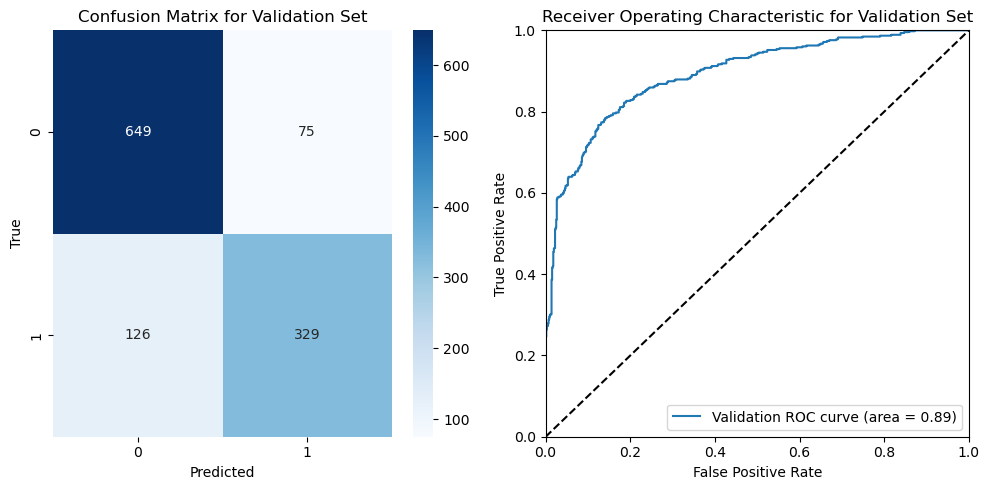

Accuracy: 0.7881433823529411
Classification Report: 
               precision    recall  f1-score   support

           0       0.77      0.88      0.82      1219
           1       0.81      0.67      0.74       957

    accuracy                           0.79      2176
   macro avg       0.79      0.78      0.78      2176
weighted avg       0.79      0.79      0.78      2176



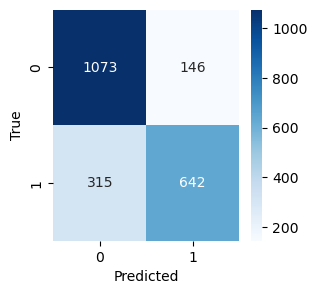

In [286]:
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred)}")

print(f"Validation Classification Report: \n {classification_report(y_val, y_val_pred)}")

cm_val = confusion_matrix(y_val, y_val_pred)
# Compute ROC curve for validation set
false_positive_rate_val, true_positive_rate_val, thresholds_val = roc_curve(y_val, logreg.predict_proba(X_val)[:, 1])

# AUC for validation set
area_under_curve_for_roc_val = auc(false_positive_rate_val, true_positive_rate_val)

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot confusion matrix on the first axis
sns.heatmap(cm_val, annot=True, fmt='g', cmap='Blues', ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title('Confusion Matrix for Validation Set')

# Plot ROC curve on the second axis
axes[1].plot(false_positive_rate_val, true_positive_rate_val, label='Validation ROC curve (area = %0.2f)' % area_under_curve_for_roc_val)
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.0])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic for Validation Set')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

# Predictions
y_pred = logreg.predict(X_test)

# Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# Classification Report
print(f"Classification Report: \n {classification_report(y_test, y_pred)}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### 4.1.2. Support Vector Machines

In [ ]:

# Initialize SVM model
svm_model = SVC(kernel='linear', C=1, random_state=42, probability=True)

# Fit the model
svm_model.fit(X_train, y_train)

# Predictions
y_pred = svm_model.predict(X_test)

# Model Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report: \n {classification_report(y_test, y_pred)}")
print(f"Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}")

# Predict probabilities
y_prob = svm_model.predict_proba(X_test)[:,1]

# Compute ROC curve and AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
area_under_curve = auc(false_positive_rate, true_positive_rate)

# Plot ROC curve
plt.figure()
plt.plot(false_positive_rate, true_positive_rate, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % area_under_curve)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 4.2. With hyperparameter tuning

#### 4.2.1. Logistic regression

In [287]:

# Define hyperparameters and their possible values
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 2, 4, 6, 8, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters
print(f"Best parameters: {grid_search.best_params_}")

# Evaluate on the test set
y_pred = grid_search.best_estimator_.predict(X_test)
print("Accuracy after GridSearchCV: ", accuracy_score(y_test, y_pred))


Fitting 5 folds for each of 40 candidates, totalling 200 fits


/opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/anacon

Best parameters: {'C': 2, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy after GridSearchCV:  0.7899816176470589


#### 4.2.2. Support Vector Machines

In [ ]:
# Define hyperparameters and their possible values
param_grid_svm = {
    'C': [0.001, 0.01, 0.1, 1, 2, 4, 6, 8, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Initialize GridSearchCV
grid_search_svm = GridSearchCV(SVC(probability=True, random_state=42), param_grid_svm, cv=5, n_jobs=-1, verbose=1)

# Fit to the training data
grid_search_svm.fit(X_train, y_train)

# Print the best parameters
print(f"Best parameters: {grid_search_svm.best_params_}")

# Evaluate on the test set
y_pred_svm = grid_search_svm.best_estimator_.predict(X_test)
print("Accuracy after GridSearchCV: ", accuracy_score(y_test, y_pred_svm))
